# Midterm - Network Request Detection
Datasets from [Web Network Traffic dataset](https://www.kaggle.com/datasets/rudrakumar96/web-firewall-good-and-bad-request/data).

## Importing Packages

In [2]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import datasets, tree
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2

## Accuracy / Confidence Interval Function

In [3]:
def print_acc_conf(model, x, y, crit = 1.64):
    accuracy = model.score(x, y)
    error = 1 - accuracy
    confidence = crit * (sqrt( (error * (1 - error)) / y.size))
    print("Accuracy:", accuracy)
    print("Confidence: %.3f" % confidence, "Lower: %.3f" % (error - confidence), "Upper: %.3f" % (error + confidence))

## Read in and Evaluate Data

In [4]:
base_path = '../datasets/network_requests/'
combine_paths = ['2bad_reqff.csv', '2good_reqff.csv']
validation_raw = pd.read_csv(base_path + 'Testing_data.csv')
badwords = ['sleep', 'uid', 'select', 'waitfor', 'delay', 'system', 'union', 'order by', 'group by', 'admin', 'drop', 'script']

combined = pd.concat([pd.read_csv(base_path + f) for f in combine_paths], ignore_index=True)

In [5]:
combined.head()

,method,path,body,single_q,double_q,dashes,braces,spaces,percentages,semicolons,angle_brackets,special_chars,path_length,body_length,badwords_count,class
0,POST,/doLogin,uid=ZAP&passw=ZAP&btnSubmit=Login,0,0,0,0,0,0,0,0,0,8,33,1,bad
1,POST,/sendFeedback,cfile=comments.txt&name=ZAP&email_addr=ZAP&sub...,0,0,0,0,7,0,0,0,0,13,124,0,bad
2,GET,/admin/clients.xls,NaN,0,0,0,0,0,0,0,0,0,18,0,1,bad
3,GET,/my%20documents/JohnSmith/Bank%20Site%20Docume...,NaN,0,0,0,0,3,0,0,0,0,57,0,0,bad
4,GET,/my%20documents/JohnSmith/Bank%20Site%20Docume...,NaN,0,0,0,0,3,0,0,0,0,82,0,0,bad


In [6]:
combined.describe()

,single_q,double_q,dashes,braces,spaces,percentages,semicolons,angle_brackets,special_chars,path_length,body_length,badwords_count
count,5797.000000,5797.000000,5797.000000,5797.000000,5797.000000,5797.0,5797.000000,5797.00000,5797.0,5797.000000,5797.000000,5797.000000
mean,0.795066,0.587373,0.183198,0.780231,4.159565,0.0,0.202691,0.27773,0.0,52.059686,51.558565,0.807314
std,1.787375,1.402760,0.427538,1.844078,6.078129,0.0,0.589890,0.91106,0.0,111.756514,116.982400,1.513214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,13.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,0.00000,0.0,33.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,7.000000,0.0,0.000000,0.00000,0.0,69.000000,86.000000,1.000000
max,12.000000,14.000000,2.000000,10.000000,40.000000,0.0,3.000000,8.00000,0.0,2162.000000,2224.000000,10.000000


In [7]:
combined.shape

(5797, 16)

In [8]:
# Find the count of nulls in each column
combined.isnull().sum(axis = 0)

method               0
path                 0
body              3396
single_q             0
double_q             0
dashes               0
braces               0
spaces               0
percentages          0
semicolons           0
angle_brackets       0
special_chars        0
path_length          0
body_length          0
badwords_count       0
class                0
dtype: int64

In [9]:
validation_raw.size

1740

## Engineer Data
We end up with:
- `data`
- `target`
- `target_names`
- `x_train_std`, `x_test_std`, `y_train_std`, and `y_test_std`
- `x_train_norm`, `x_test_norm`, `y_train_norm`, and `y_test_norm`
- `x_train_down`, `x_test_norm`, `y_train_down`, and `y_test_norm`
- `x_train_chi`, `x_test_chi`, `y_train_chi`, and `y_test_chi`
- `x_smoteenn`, `y_smoteenn`
- `x_oversampled`, `y_oversampled`
- `validation`

TODO
- [x] Try with normalized rather than standard scaler (Didn't seem to have any change)
- [x] Downsample
- [x] Try Chi-square test to limit features (made it worse?)
- [x] Find confidence interval for significant results

### Remove Path and Body Columns

In [10]:
dropped = combined.drop(columns=['path', 'body'])
dropped.head()

,method,single_q,double_q,dashes,braces,spaces,percentages,semicolons,angle_brackets,special_chars,path_length,body_length,badwords_count,class
0,POST,0,0,0,0,0,0,0,0,0,8,33,1,bad
1,POST,0,0,0,0,7,0,0,0,0,13,124,0,bad
2,GET,0,0,0,0,0,0,0,0,0,18,0,1,bad
3,GET,0,0,0,0,3,0,0,0,0,57,0,0,bad
4,GET,0,0,0,0,3,0,0,0,0,82,0,0,bad


### Split Dataset `data`, `cols`, `target`, and `target_names` variables

In [11]:
data = dropped.drop(columns='class')
cols = data.columns
target = dropped['class'].map({'bad': 0, 'good': 1})
target_names = dropped['class'].unique()

print(target)
print(target_names)
print(data.shape, cols.shape)
print(target[target == 0].shape)
print(target[target == 1].shape)

0       0
1       0
2       0
3       0
4       0
       ..
5792    1
5793    1
5794    1
5795    1
5796    1
Name: class, Length: 5797, dtype: int64
['bad' 'good']
(5797, 13) (13,)
(5510,)
(287,)


### One-Hot Encode 'method' Column

In [12]:
print(data['method'].unique())

['POST' 'GET']


In [13]:
data['method'] = data['method'].map({'GET': 0, 'POST': 1})
data.head()

,method,single_q,double_q,dashes,braces,spaces,percentages,semicolons,angle_brackets,special_chars,path_length,body_length,badwords_count
0,1,0,0,0,0,0,0,0,0,0,8,33,1
1,1,0,0,0,0,7,0,0,0,0,13,124,0
2,0,0,0,0,0,0,0,0,0,0,18,0,1
3,0,0,0,0,0,3,0,0,0,0,57,0,0
4,0,0,0,0,0,3,0,0,0,0,82,0,0


## Save Data to CSV

In [70]:
data.to_csv(base_path + 'engineered.csv', index=False, header=True)
target.to_csv(base_path + 'engineered-target.csv', index=False, header=True)
pd.DataFrame(target_names).to_csv(base_path + 'target-names.csv', index=False, header=True)

### Normalize Count Columns (Both MinMax and Standard Scalers)

In [14]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(data)
minmax = minmax_scaler.transform(data)
print(minmax[0])

scaler = StandardScaler()
scaler.fit(data)
standard = scaler.transform(data)
print(standard[0])

[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00323924 0.01483813
 0.1       ]
[ 1.19098267 -0.44486184 -0.41876262 -0.4285327  -0.42313745 -0.68440867
  0.         -0.34363762 -0.30486888  0.         -0.39428115 -0.15865776
  0.12734653]


### Run Chi-square Test

In [15]:
chi2_stats, p_values = chi2(minmax, target)
print(chi2_stats)
print(p_values)

[118.62008022  20.0057925   12.66833031  27.65825771  23.55900181
  31.13694373          nan  20.40078645  10.48253176          nan
   1.18731948   6.8270217   24.16680616]
[1.26838391e-27 7.72079270e-06 3.71901502e-04 1.44752808e-07
 1.21141347e-06 2.40451222e-08            nan 6.28039803e-06
 1.20508504e-03            nan 2.75870917e-01 8.97888622e-03
 8.83418569e-07]


In [16]:
p_sorted = pd.Series(p_values, index = cols)
p_sorted.sort_values(ascending = False, inplace = True)

<Axes: >

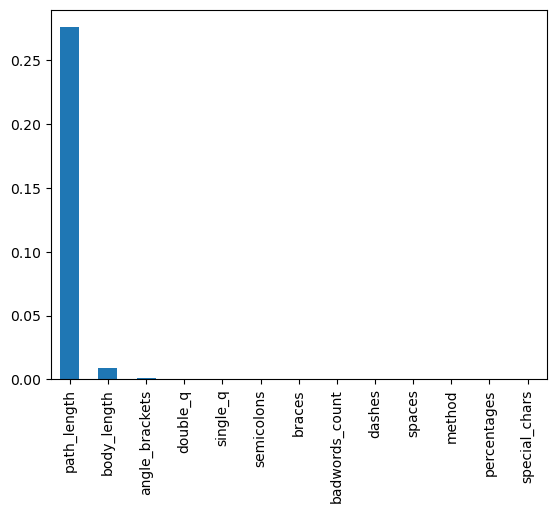

In [17]:
p_sorted.plot.bar()

### Create Another Dataset with `path_length` and `body_length` columns removed

In [18]:
path_len_idx = cols.get_loc('path_length')
body_len_idx = cols.get_loc('body_length')
print(path_len_idx, body_len_idx)
chi_norm = np.delete(minmax, [path_len_idx, body_len_idx], axis=1) 
chi_norm.shape

10 11


(5797, 11)

### Split Data into Train/Test (80/20)

In [19]:
x_train_std, x_test_std, y_train_std, y_test_std = train_test_split(standard, target, test_size=0.20, stratify=target, random_state=81)

In [20]:
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(minmax, target, test_size=0.20, stratify=target, random_state=81)

In [21]:
x_train_chi, x_test_chi, y_train_chi, y_test_chi = train_test_split(chi_norm, target, test_size=0.20, stratify=target, random_state=81)

In [22]:
print(x_train_std.shape)
x_train_std

(4637, 13)


array([[-0.83964278, -0.44486184, -0.41876262, ..., -0.07212449,
        -0.44077581, -0.53355572],
       [-0.83964278, -0.44486184, -0.41876262, ..., -0.08107328,
        -0.44077581, -0.53355572],
       [ 1.19098267, -0.44486184,  0.2941792 , ..., -0.34953717,
         0.850128  ,  0.12734653],
       ...,
       [ 1.19098267, -0.44486184,  1.00712102, ..., -0.35848596,
        -0.00477519, -0.53355572],
       [-0.83964278,  1.79324975,  1.00712102, ...,  1.36863169,
        -0.44077581,  2.11005327],
       [-0.83964278,  1.79324975,  2.43300465, ...,  1.01067984,
        -0.44077581,  0.12734653]])

In [23]:
print(np.unique(y_train_std, return_counts=True))
print(np.unique(y_test_std, return_counts=True))

(array([0, 1]), array([4407,  230]))
(array([0, 1]), array([1103,   57]))


### Resample by Downsampling 'Bad' Class (Using MinMax Normalized Data)

In [24]:
print("Original Shape:", x_train_norm.shape)

# Create masks to grab elements from the two classes
y_mask_0 = y_train_norm == 0
y_mask_1 = y_train_norm == 1
# Class 0
x_0 = x_train_norm[y_mask_0]
y_0 = y_train_norm[y_mask_0]
# Class 1
x_1 = x_train_norm[y_mask_1]
y_1 = y_train_norm[y_mask_1]

print("x_0 shape:", x_0.shape, "y_0 shape:", y_0.shape)
print("x_1 shape:", x_1.shape, "y_1 shape:", y_1.shape)

# Selecting random samples from class "0" (a bit more than class "1")
x_0_down, y_0_down = resample(x_0, y_0, replace=False, n_samples=500, random_state=39)

# Concate "0" class back with "1"
x_train_down = np.concatenate([x_0_down, x_1])
y_train_down = np.concatenate([y_0_down, y_1])
# Shuffle
x_train_down, y_train_down = shuffle(x_train_down, y_train_down, random_state=72)
print(x_train_down.shape)

Original Shape: (4637, 13)
x_0 shape: (4407, 13) y_0 shape: (4407,)
x_1 shape: (230, 13) y_1 shape: (230,)
(730, 13)


### Resample Data with SMOTEENN

In [25]:
smoteenn = SMOTEENN(random_state=38)
x_smoteenn, y_smoteenn= smoteenn.fit_resample(x_train_std, y_train_std)

### Resample Data by Resampling Duplicating

In [26]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13, shrinkage=0.3)
x_oversampled, y_oversampled = oversample.fit_resample(x_train_std, y_train_std)

### Resample Chi Data by Resampling Duplicating

In [27]:
x_over_chi, y_over_chi = oversample.fit_resample(x_train_chi, y_train_chi)

### Resample Testing Data with SMOTEENN

In [28]:
x_test_org, y_test_org = x_test_std, y_test_std
x_test_std, y_test_std = smoteenn.fit_resample(x_test_std, y_test_std)
x_test_norm, y_test_norm = smoteenn.fit_resample(x_test_norm, y_test_norm)
# x_test_chi, y_test_chi = smoteenn.fit_resample(x_test_chi, y_test_chi)

### Perform Same Operations on Validation Dataset (Unused)

In [72]:
# Drop 'path' and 'body' columns
validation = validation_raw.drop(columns=['path', 'body'])
# Bindary Encode 'method' column
validation['method'] = validation['method'].map({'GET': 0, 'POST': 1})
validation.to_csv(base_path + 'validation.csv', index=False, header=True)
# Normalize Columns
val_scaler = StandardScaler()
val_scaler.fit(validation)
validation = val_scaler.transform(validation)
print(validation.shape)
validation

(116, 13)


array([[ 2.94392029,  0.        ,  0.        , ..., -1.50750536,
         0.67923546,  1.70722012],
       [ 2.94392029,  0.        ,  0.        , ..., -1.28875302,
         3.37878724, -0.44536177],
       [-0.33968311,  0.        ,  0.        , ..., -1.07000068,
        -0.29972288,  1.70722012],
       ...,
       [-0.33968311,  0.        ,  0.        , ..., -0.15124084,
        -0.29972288, -0.44536177],
       [-0.33968311,  0.        ,  0.        , ..., -0.67624646,
        -0.29972288, -0.44536177],
       [-0.33968311,  0.        ,  0.        , ..., -0.15124084,
        -0.29972288, -0.44536177]])

## K Nearest Neighbors (6 Methods)

In [30]:
def knn(x, y, x_test, y_test, names, neighbors):
    # Train Model
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(x, y)
    # Make Predictions
    knn_pred = knn.predict(x_test)
    # Get Reports
    print(confusion_matrix(y_test, knn_pred), '\n')
    print(classification_report(y_test, knn_pred, target_names=names))
    print_acc_conf(knn, x_test, y_test)

### Train with Raw Standard Scaler Data

In [31]:
knn(x_train_std, y_train_std, x_test_std, y_test_std, target_names, 10)

[[1064    0]
 [ 197  575]] 

              precision    recall  f1-score   support

         bad       0.84      1.00      0.92      1064
        good       1.00      0.74      0.85       772

    accuracy                           0.89      1836
   macro avg       0.92      0.87      0.88      1836
weighted avg       0.91      0.89      0.89      1836

Accuracy: 0.8927015250544662
Confidence: 0.012 Lower: 0.095 Upper: 0.119


### Train with Raw MinMax Scaler Data

In [32]:
knn(x_train_norm, y_train_norm, x_test_norm, y_test_norm, target_names, 10)

[[1061    0]
 [ 202  572]] 

              precision    recall  f1-score   support

         bad       0.84      1.00      0.91      1061
        good       1.00      0.74      0.85       774

    accuracy                           0.89      1835
   macro avg       0.92      0.87      0.88      1835
weighted avg       0.91      0.89      0.89      1835

Accuracy: 0.8899182561307902
Confidence: 0.012 Lower: 0.098 Upper: 0.122


### Train with SMOTEENN Data

In [33]:
knn(x_smoteenn, y_smoteenn, x_test_std, y_test_std, target_names, 10)

[[1036   28]
 [  88  684]] 

              precision    recall  f1-score   support

         bad       0.92      0.97      0.95      1064
        good       0.96      0.89      0.92       772

    accuracy                           0.94      1836
   macro avg       0.94      0.93      0.93      1836
weighted avg       0.94      0.94      0.94      1836

Accuracy: 0.9368191721132898
Confidence: 0.009 Lower: 0.054 Upper: 0.072


### Train with Oversampled Data

In [34]:
knn(x_oversampled, y_oversampled, x_test_std, y_test_std, target_names, 10)

[[1064    0]
 [ 194  578]] 

              precision    recall  f1-score   support

         bad       0.85      1.00      0.92      1064
        good       1.00      0.75      0.86       772

    accuracy                           0.89      1836
   macro avg       0.92      0.87      0.89      1836
weighted avg       0.91      0.89      0.89      1836

Accuracy: 0.8943355119825708
Confidence: 0.012 Lower: 0.094 Upper: 0.117


### Train with Oversampled Data - Test with un-balanced data

In [35]:
knn(x_oversampled, y_oversampled, x_test_org, y_test_org, target_names, 10)

[[1098    5]
 [  23   34]] 

              precision    recall  f1-score   support

         bad       0.98      1.00      0.99      1103
        good       0.87      0.60      0.71        57

    accuracy                           0.98      1160
   macro avg       0.93      0.80      0.85      1160
weighted avg       0.97      0.98      0.97      1160

Accuracy: 0.9758620689655172
Confidence: 0.007 Lower: 0.017 Upper: 0.032


### Train with Downsampled Data

In [36]:
knn(x_train_down, y_train_down, x_test_norm, y_test_norm, target_names, 10)

[[1011   50]
 [  24  750]] 

              precision    recall  f1-score   support

         bad       0.98      0.95      0.96      1061
        good       0.94      0.97      0.95       774

    accuracy                           0.96      1835
   macro avg       0.96      0.96      0.96      1835
weighted avg       0.96      0.96      0.96      1835

Accuracy: 0.9596730245231607
Confidence: 0.008 Lower: 0.033 Upper: 0.048


### Train with Oversampled Chi Data

In [37]:
knn(x_over_chi, y_over_chi, x_test_chi, y_test_chi, target_names, 10)

[[1103    0]
 [  57    0]] 

              precision    recall  f1-score   support

         bad       0.95      1.00      0.97      1103
        good       0.00      0.00      0.00        57

    accuracy                           0.95      1160
   macro avg       0.48      0.50      0.49      1160
weighted avg       0.90      0.95      0.93      1160

Accuracy: 0.9508620689655173
Confidence: 0.010 Lower: 0.039 Upper: 0.060


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

## Decision Trees (6 Methods)

In [38]:
def treeModel(x, y, x_test, y_test, names):
    # Train Model
    tree_model = tree.DecisionTreeClassifier()
    tree_model = tree_model.fit(x, y)
    # Make Predictions
    trees_pred = tree_model.predict(x_test)
    # Get Reports on Test
    print(confusion_matrix(y_test, trees_pred))
    print(classification_report(y_test, trees_pred, target_names=names))
    print_acc_conf(tree_model, x_test, y_test)

### Train with Raw Standard Scaler Data

In [39]:
treeModel(x_train_std, y_train_std, x_test_std, y_test_std, target_names)

[[1060    4]
 [ 179  593]]
              precision    recall  f1-score   support

         bad       0.86      1.00      0.92      1064
        good       0.99      0.77      0.87       772

    accuracy                           0.90      1836
   macro avg       0.92      0.88      0.89      1836
weighted avg       0.91      0.90      0.90      1836

Accuracy: 0.9003267973856209
Confidence: 0.011 Lower: 0.088 Upper: 0.111


### Train with Raw MinMax Scaler Data

In [40]:
treeModel(x_train_norm, y_train_norm, x_test_norm, y_test_norm, target_names)

[[1057    4]
 [ 183  591]]
              precision    recall  f1-score   support

         bad       0.85      1.00      0.92      1061
        good       0.99      0.76      0.86       774

    accuracy                           0.90      1835
   macro avg       0.92      0.88      0.89      1835
weighted avg       0.91      0.90      0.90      1835

Accuracy: 0.8980926430517712
Confidence: 0.012 Lower: 0.090 Upper: 0.113


### Train with SMOTEENN Data

In [41]:
treeModel(x_smoteenn, y_smoteenn, x_test_std, y_test_std, target_names)

[[1034   30]
 [ 372  400]]
              precision    recall  f1-score   support

         bad       0.74      0.97      0.84      1064
        good       0.93      0.52      0.67       772

    accuracy                           0.78      1836
   macro avg       0.83      0.74      0.75      1836
weighted avg       0.82      0.78      0.77      1836

Accuracy: 0.7810457516339869
Confidence: 0.016 Lower: 0.203 Upper: 0.235


### Train with Oversampled Data

In [42]:
treeModel(x_oversampled, y_oversampled, x_test_std, y_test_std, target_names)

[[1060    4]
 [ 179  593]]
              precision    recall  f1-score   support

         bad       0.86      1.00      0.92      1064
        good       0.99      0.77      0.87       772

    accuracy                           0.90      1836
   macro avg       0.92      0.88      0.89      1836
weighted avg       0.91      0.90      0.90      1836

Accuracy: 0.9003267973856209
Confidence: 0.011 Lower: 0.088 Upper: 0.111


In [66]:
treeModel(x_oversampled, y_oversampled, x_test_org, y_test_org, target_names)

[[1094    9]
 [  21   36]]
              precision    recall  f1-score   support

         bad       0.98      0.99      0.99      1103
        good       0.80      0.63      0.71        57

    accuracy                           0.97      1160
   macro avg       0.89      0.81      0.85      1160
weighted avg       0.97      0.97      0.97      1160

Accuracy: 0.9741379310344828
Confidence: 0.008 Lower: 0.018 Upper: 0.034


### Train with Downsampled Data

In [43]:
treeModel(x_train_down, y_train_down, x_test_norm, y_test_norm, target_names)

[[1003   58]
 [  44  730]]
              precision    recall  f1-score   support

         bad       0.96      0.95      0.95      1061
        good       0.93      0.94      0.93       774

    accuracy                           0.94      1835
   macro avg       0.94      0.94      0.94      1835
weighted avg       0.94      0.94      0.94      1835

Accuracy: 0.9444141689373297
Confidence: 0.009 Lower: 0.047 Upper: 0.064


### Train with Chi Oversample Data

In [44]:
treeModel(x_over_chi, y_over_chi, x_test_chi, y_test_chi, target_names)

[[1103    0]
 [  57    0]]
              precision    recall  f1-score   support

         bad       0.95      1.00      0.97      1103
        good       0.00      0.00      0.00        57

    accuracy                           0.95      1160
   macro avg       0.48      0.50      0.49      1160
weighted avg       0.90      0.95      0.93      1160

Accuracy: 0.9508620689655173
Confidence: 0.010 Lower: 0.039 Upper: 0.060


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

## Logistic Regression (6 Methods)

In [45]:
def logres(x, y, x_test, y_test, names):
    # Train Model
    log_model = LogisticRegression(random_state=38, max_iter=1000).fit(x, y)
    # Make Predictions
    log_pred = log_model.predict(x_test)
    # Get Reports
    print(confusion_matrix(y_test, log_pred))
    print(classification_report(y_test, log_pred, target_names=names))
    print_acc_conf(log_model, x_test, y_test)

### Train with Raw Standard Scaler Data

In [46]:
logres(x_train_std, y_train_std, x_test_std, y_test_std, target_names)

[[1064    0]
 [ 772    0]]
              precision    recall  f1-score   support

         bad       0.58      1.00      0.73      1064
        good       0.00      0.00      0.00       772

    accuracy                           0.58      1836
   macro avg       0.29      0.50      0.37      1836
weighted avg       0.34      0.58      0.43      1836

Accuracy: 0.579520697167756
Confidence: 0.019 Lower: 0.402 Upper: 0.439


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### Train with Raw MinMax Scaler Data

In [47]:
logres(x_train_norm, y_train_norm, x_test_norm, y_test_norm, target_names)

[[1061    0]
 [ 774    0]]
              precision    recall  f1-score   support

         bad       0.58      1.00      0.73      1061
        good       0.00      0.00      0.00       774

    accuracy                           0.58      1835
   macro avg       0.29      0.50      0.37      1835
weighted avg       0.33      0.58      0.42      1835

Accuracy: 0.5782016348773842
Confidence: 0.019 Lower: 0.403 Upper: 0.441


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### Train with SMOTEENN Data

In [48]:
logres(x_smoteenn, y_smoteenn, x_test_std, y_test_std, target_names)

[[945 119]
 [  0 772]]
              precision    recall  f1-score   support

         bad       1.00      0.89      0.94      1064
        good       0.87      1.00      0.93       772

    accuracy                           0.94      1836
   macro avg       0.93      0.94      0.93      1836
weighted avg       0.94      0.94      0.94      1836

Accuracy: 0.9351851851851852
Confidence: 0.009 Lower: 0.055 Upper: 0.074


### Train with Oversampled Data

In [49]:
logres(x_oversampled, y_oversampled, x_test_std, y_test_std, target_names)

[[907 157]
 [  0 772]]
              precision    recall  f1-score   support

         bad       1.00      0.85      0.92      1064
        good       0.83      1.00      0.91       772

    accuracy                           0.91      1836
   macro avg       0.92      0.93      0.91      1836
weighted avg       0.93      0.91      0.92      1836

Accuracy: 0.914488017429194
Confidence: 0.011 Lower: 0.075 Upper: 0.096


### Train with Downsampled Data

In [50]:
logres(x_train_down, y_train_down, x_test_norm, y_test_norm, target_names)

[[830 231]
 [  0 774]]
              precision    recall  f1-score   support

         bad       1.00      0.78      0.88      1061
        good       0.77      1.00      0.87       774

    accuracy                           0.87      1835
   macro avg       0.89      0.89      0.87      1835
weighted avg       0.90      0.87      0.87      1835

Accuracy: 0.8741144414168938
Confidence: 0.013 Lower: 0.113 Upper: 0.139


### Train with Chi Oversampled Data

In [51]:
logres(x_over_chi, y_over_chi, x_test_chi, y_test_chi, target_names)

[[795 308]
 [  0  57]]
              precision    recall  f1-score   support

         bad       1.00      0.72      0.84      1103
        good       0.16      1.00      0.27        57

    accuracy                           0.73      1160
   macro avg       0.58      0.86      0.55      1160
weighted avg       0.96      0.73      0.81      1160

Accuracy: 0.7344827586206897
Confidence: 0.021 Lower: 0.244 Upper: 0.287


## Support Vector Machines (6 Methods)

In [52]:
def svm(x, y, x_test, y_test, names):
    # Train Model
    svc_model = SVC()
    svc_model.fit(x, y)
    # Make Predictions
    svc_pred = svc_model.predict(x_test)
    # Get Reports
    print(confusion_matrix(y_test, svc_pred))
    print(classification_report(y_test, svc_pred, target_names=names))
    print_acc_conf(svc_model, x_test, y_test)

### Train with Raw Standard Scaler Data

In [53]:
svm(x_train_std, y_train_std, x_test_std, y_test_std, target_names)

[[1064    0]
 [ 772    0]]
              precision    recall  f1-score   support

         bad       0.58      1.00      0.73      1064
        good       0.00      0.00      0.00       772

    accuracy                           0.58      1836
   macro avg       0.29      0.50      0.37      1836
weighted avg       0.34      0.58      0.43      1836

Accuracy: 0.579520697167756
Confidence: 0.019 Lower: 0.402 Upper: 0.439


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### Train with Raw MinMax Scaler Data

In [54]:
svm(x_train_norm, y_train_norm, x_test_norm, y_test_norm, target_names)

[[1061    0]
 [ 774    0]]
              precision    recall  f1-score   support

         bad       0.58      1.00      0.73      1061
        good       0.00      0.00      0.00       774

    accuracy                           0.58      1835
   macro avg       0.29      0.50      0.37      1835
weighted avg       0.33      0.58      0.42      1835

Accuracy: 0.5782016348773842
Confidence: 0.019 Lower: 0.403 Upper: 0.441


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### Train with SMOTEENN Data

In [55]:
svm(x_smoteenn, y_smoteenn, x_test_std, y_test_std, target_names)

[[927 137]
 [  0 772]]
              precision    recall  f1-score   support

         bad       1.00      0.87      0.93      1064
        good       0.85      1.00      0.92       772

    accuracy                           0.93      1836
   macro avg       0.92      0.94      0.92      1836
weighted avg       0.94      0.93      0.93      1836

Accuracy: 0.9253812636165577
Confidence: 0.010 Lower: 0.065 Upper: 0.085


### Train with Oversampled Data

In [56]:
svm(x_oversampled, y_oversampled, x_test_std, y_test_std, target_names)

[[903 161]
 [  0 772]]
              precision    recall  f1-score   support

         bad       1.00      0.85      0.92      1064
        good       0.83      1.00      0.91       772

    accuracy                           0.91      1836
   macro avg       0.91      0.92      0.91      1836
weighted avg       0.93      0.91      0.91      1836

Accuracy: 0.9123093681917211
Confidence: 0.011 Lower: 0.077 Upper: 0.099


### Train with Downsampled Data

In [57]:
svm(x_train_down, y_train_down, x_test_norm, y_test_norm, target_names)

[[810 251]
 [  0 774]]
              precision    recall  f1-score   support

         bad       1.00      0.76      0.87      1061
        good       0.76      1.00      0.86       774

    accuracy                           0.86      1835
   macro avg       0.88      0.88      0.86      1835
weighted avg       0.90      0.86      0.86      1835

Accuracy: 0.8632152588555858
Confidence: 0.013 Lower: 0.124 Upper: 0.150


### Train with Oversampled Chi Data

In [58]:
svm(x_over_chi, y_over_chi, x_test_chi, y_test_chi, target_names)

[[872 231]
 [  0  57]]
              precision    recall  f1-score   support

         bad       1.00      0.79      0.88      1103
        good       0.20      1.00      0.33        57

    accuracy                           0.80      1160
   macro avg       0.60      0.90      0.61      1160
weighted avg       0.96      0.80      0.86      1160

Accuracy: 0.8008620689655173
Confidence: 0.019 Lower: 0.180 Upper: 0.218


## Artificial Neural Networks (6 Methods)

In [59]:
def ann(x, y, x_test, y_test, names, layers = (100,), seed = 1, epochs = 1000):
    # Train Model
    ann = MLPClassifier(random_state = seed, max_iter = epochs, hidden_layer_sizes = layers).fit(x, y) 
    # Make Predictions
    ann_pred = ann.predict(x_test)
    # Get Reports
    print(confusion_matrix(y_test, ann_pred))
    print(classification_report(y_test, ann_pred, target_names=names))
    print_acc_conf(ann, x_test, y_test) 

### Train with Raw Standard Scaler Data

In [60]:
ann(x_train_std, y_train_std, x_test_std, y_test_std, target_names)

[[1064    0]
 [ 772    0]]
              precision    recall  f1-score   support

         bad       0.58      1.00      0.73      1064
        good       0.00      0.00      0.00       772

    accuracy                           0.58      1836
   macro avg       0.29      0.50      0.37      1836
weighted avg       0.34      0.58      0.43      1836

Accuracy: 0.579520697167756
Confidence: 0.019 Lower: 0.402 Upper: 0.439


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### Train with Raw MinMax Scaler Data

In [61]:
ann(x_train_norm, y_train_norm, x_test_norm, y_test_norm, target_names)

[[1061    0]
 [ 774    0]]
              precision    recall  f1-score   support

         bad       0.58      1.00      0.73      1061
        good       0.00      0.00      0.00       774

    accuracy                           0.58      1835
   macro avg       0.29      0.50      0.37      1835
weighted avg       0.33      0.58      0.42      1835

Accuracy: 0.5782016348773842
Confidence: 0.019 Lower: 0.403 Upper: 0.441


/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/python-labs/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### Train with SMOTEENN Data 

In [62]:
ann(x_smoteenn, y_smoteenn, x_test_std, y_test_std, target_names)

[[987  77]
 [  3 769]]
              precision    recall  f1-score   support

         bad       1.00      0.93      0.96      1064
        good       0.91      1.00      0.95       772

    accuracy                           0.96      1836
   macro avg       0.95      0.96      0.96      1836
weighted avg       0.96      0.96      0.96      1836

Accuracy: 0.9564270152505446
Confidence: 0.008 Lower: 0.036 Upper: 0.051


### Train with Oversampled Data

In [63]:
ann(x_oversampled, y_oversampled, x_test_std, y_test_std, target_names)

[[936 128]
 [  0 772]]
              precision    recall  f1-score   support

         bad       1.00      0.88      0.94      1064
        good       0.86      1.00      0.92       772

    accuracy                           0.93      1836
   macro avg       0.93      0.94      0.93      1836
weighted avg       0.94      0.93      0.93      1836

Accuracy: 0.9302832244008714
Confidence: 0.010 Lower: 0.060 Upper: 0.079


### Training with Downsampled Data

In [64]:
ann(x_train_down, y_train_down, x_test_norm, y_test_norm, target_names)

[[930 131]
 [  0 774]]
              precision    recall  f1-score   support

         bad       1.00      0.88      0.93      1061
        good       0.86      1.00      0.92       774

    accuracy                           0.93      1835
   macro avg       0.93      0.94      0.93      1835
weighted avg       0.94      0.93      0.93      1835

Accuracy: 0.9286103542234332
Confidence: 0.010 Lower: 0.062 Upper: 0.081


### Train with Oversampled Chi Data

In [65]:
ann(x_over_chi, y_over_chi, x_test_chi, y_test_chi, target_names)

[[911 192]
 [  0  57]]
              precision    recall  f1-score   support

         bad       1.00      0.83      0.90      1103
        good       0.23      1.00      0.37        57

    accuracy                           0.83      1160
   macro avg       0.61      0.91      0.64      1160
weighted avg       0.96      0.83      0.88      1160

Accuracy: 0.8344827586206897
Confidence: 0.018 Lower: 0.148 Upper: 0.183
